In [1]:

import pandas as pd
import numpy as np
from skimage.io import imread
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
import keras
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import cv2

In [2]:

train_df = pd.read_csv('3labels_csv_station.csv', index_col=0)
train_df= train_df[['files_name','classID']]
train_df['Z'] = train_df.index.map(lambda id: f'spectogram_typesquare/{id}_Z.png')
train_df['N'] = train_df.index.map(lambda id: f'spectogram_typesquare/{id}_N.png')
train_df['E'] = train_df.index.map(lambda id: f'spectogram_typesquare/{id}_E.png')


# print(train_df.head())

In [3]:
def preprocess_spectogram(paths,resize,gray):
    """
    """
    if gray == True:
        channels = 1
    else:
        channels = 4

    images = []
    for file_path in paths:
        img = imread(file_path,as_gray = gray)
        scale_percent = resize
        width = int(img.shape[1] * scale_percent / 100)
        height = int(img.shape[0] * scale_percent / 100)
        dim = (width, height)
        img_resize = cv2.resize(img, dim)
        images.append(img_resize)
    images = np.asarray(images, dtype=np.float32)
    images = images / 255.0
    images.shape

    if gray == False:
        images = images.reshape(images.shape[1], images.shape[2], channels)
    else:
        images = images.reshape(images.shape[0], images.shape[1], images.shape[2], channels)
    
    input_shape = images.shape 
    # print(f'image is {channels} \n {images.shape}')

    return images, input_shape


In [4]:
gray = True
resize = 20
num_classes = 3
batch_size = 64
epochs = 1000



#init_preprocess
imagesZ, input_shapeZ = preprocess_spectogram(train_df.Z.values, resize, gray)
#init_preprocess
imagesN, input_shapeN = preprocess_spectogram(train_df.N.values, resize, gray)
#init_preprocess
imagesE, input_shapeE = preprocess_spectogram(train_df.E.values, resize, gray)


In [5]:
# getShape
# print(imagesZ)
input_shapeZNE = (imagesZ.shape[1], imagesZ.shape[2], 1)
input_img = Input(shape= input_shapeZNE)
print(input_shapeZNE)
print(input_img)

(77, 77, 1)
KerasTensor(type_spec=TensorSpec(shape=(None, 77, 77, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [6]:

# Z files
x_train_Z = imagesZ
# print(x_train_Z)
# N files
x_train_N = imagesN

# N files
x_train_E = imagesE

# labels - convert class vectors to binary class matrices One Hot Encoding
labels = train_df.classID.values
labels = to_categorical(labels, num_classes)

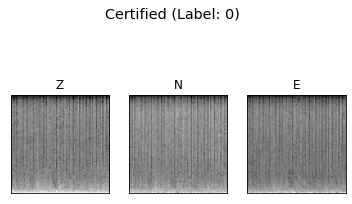

In [7]:
classTarget = [
    'Certified', 
    'Usable', 
    'Unusable'
]

# pick a random index from the list
rn_appliance = np.random.choice(train_df.classID.values)
rn_label = train_df.classID.values[rn_appliance]

rn_Z = x_train_Z[rn_appliance]
rn_N = x_train_N[rn_appliance]
rn_E = x_train_E[rn_appliance]

plt.figure()
plt.axis('off')
plt.suptitle(f"{classTarget[rn_label]} (Label: {rn_label})", fontsize="x-large")
# Z
plt.subplot(131)
curr_img = None
if gray:
  curr_img = np.reshape(rn_Z,(imagesZ.shape[1], imagesZ.shape[2]))
else:
  curr_img = np.reshape(rn_Z,(input_shapeZ))
plt.imshow(curr_img, cmap='gray')
plt.title("Z")
plt.xticks([])
plt.yticks([])
# N
plt.subplot(132)
if gray:
  curr_img = np.reshape(rn_N,(imagesN.shape[1], imagesN.shape[2]))
else:
  curr_img = np.reshape(rn_N,(input_shapeN))
plt.imshow(curr_img, cmap='gray')
plt.title("N")
plt.xticks([])
plt.yticks([])
# E
plt.subplot(133)
if gray:
  curr_img = np.reshape(rn_E,(imagesE.shape[1], imagesE.shape[2]))
else:
  curr_img = np.reshape(rn_N,(input_shapeN))
plt.imshow(curr_img, cmap='gray')
plt.title("E")
plt.xticks([])
plt.yticks([])

plt.show()

In [8]:
# stack so we can split on the same pair of images
x_train_comp = np.stack((x_train_Z, x_train_N, x_train_E), axis=3)
# print(x_train_comp.shape)

x_train, x_test, y_train, y_test = train_test_split(x_train_comp, labels, test_size = 0.2, random_state=666)

# take them apart
x_train_Z = x_train[:,:,:,0]
x_test_Z = x_test[:,:,:,0]

x_train_N = x_train[:,:,:,1]
x_test_N = x_test[:,:,:,1]

x_train_E = x_train[:,:,:,2]
x_test_E = x_test[:,:,:,2]

In [9]:
def create_convolution_layers(input_img):
    model = Conv2D(32, (3, 3), padding='same', input_shape=input_shapeZNE)(input_img)
    # model = LeakyReLU(alpha=0.1)(model)
    model = MaxPooling2D((2, 2),padding='same')(model)
    model = Dropout(0.25)(model)
    
    model = Conv2D(64, (3, 3), padding='same')(model)
    # model = LeakyReLU(alpha=0.1)(model)
    model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
    model = Dropout(0.25)(model)
    
    model = Conv2D(128, (3, 3), padding='same')(model)
    # model = LeakyReLU(alpha=0.1)(model)
    model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
    model = Dropout(0.4)(model)
    
    return model

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

KerasTensor(type_spec=TensorSpec(shape=(None, 77, 77, 1), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


2022-06-25 11:30:12.614404: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-25 11:30:12.616491: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 77, 77, 1)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 77, 77, 1)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 77, 77, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 77, 77, 32)   320         ['input_2[0][0]']                
                                                                                              

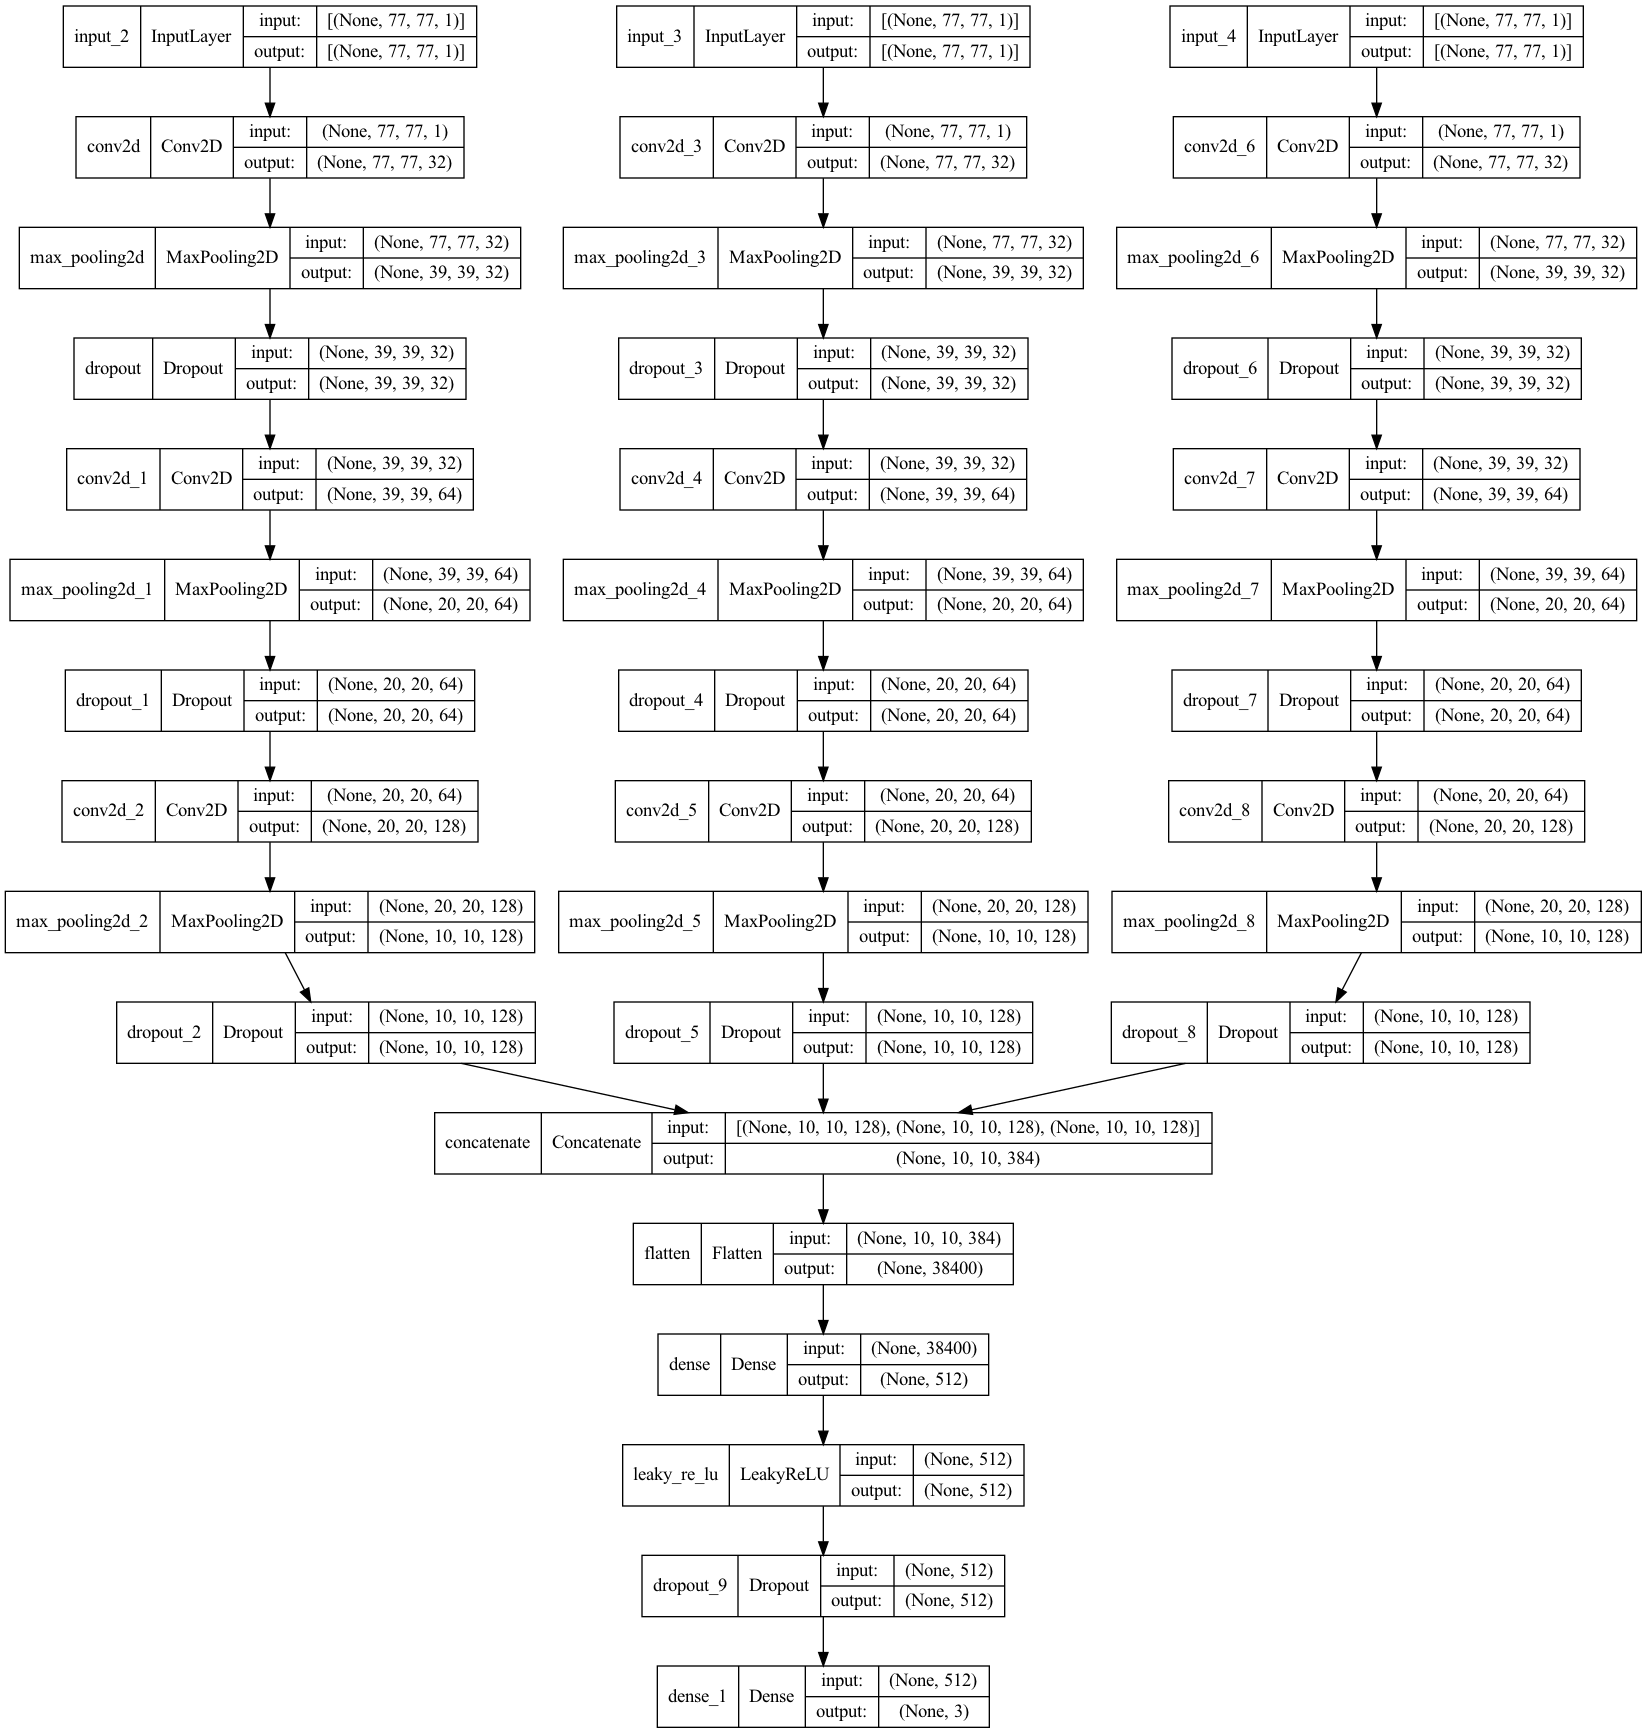

In [10]:
Z_input = Input(shape=input_shapeZNE)
Z_model = create_convolution_layers(Z_input)

print(Z_input)

N_input = Input(shape=input_shapeZNE)
N_model = create_convolution_layers(N_input)

E_input = Input(shape=input_shapeZNE)
E_model = create_convolution_layers(E_input)

conv = concatenate([Z_model, N_model, E_model])

conv = Flatten()(conv)

dense = Dense(512)(conv)
dense = LeakyReLU(alpha=0.1)(dense)
dense = Dropout(0.5)(dense)

output = Dense(num_classes, activation='softmax')(dense)

model = Model(inputs=[Z_input, N_input, E_input], outputs=[output])

opt = optimizers.Adam(learning_rate=0.5e-3)

model.compile( loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [11]:
# best_weights_file="NoiseModel_24May2022.hdf5"
# model.save(best_weights_file)
filepath = 'M1_(1000)MICNN_Model_without_relu_77x77'
tf.keras.models.save_model(model, filepath)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks = [checkpoint]

history  = model.fit([x_train_Z, x_train_N, x_train_E], y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks,
          verbose=1,
          validation_data=([x_test_Z, x_test_N, x_test_E], y_test),
          shuffle=True)

2022-06-25 11:30:35.421117: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: M1_(1000)MICNN_Model_without_relu_77x77/assets


2022-06-25 11:30:37.928802: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/1000


2022-06-25 11:30:38.467008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


52/52 [==============================] - ETA: 0s - loss: 0.8249 - accuracy: 0.6884

2022-06-25 11:30:48.162231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_accuracy improved from -inf to 0.69928, saving model to M1_(1000)MICNN_Model_without_relu_77x77
INFO:tensorflow:Assets written to: M1_(1000)MICNN_Model_without_relu_77x77/assets
52/52 [==============================] - 15s 258ms/step - loss: 0.8249 - accuracy: 0.6884 - val_loss: 0.7832 - val_accuracy: 0.6993
Epoch 2/1000
52/52 [==============================] - ETA: 0s - loss: 0.7977 - accuracy: 0.6972
Epoch 00002: val_accuracy did not improve from 0.69928
52/52 [==============================] - 9s 173ms/step - loss: 0.7977 - accuracy: 0.6972 - val_loss: 0.7758 - val_accuracy: 0.6993
Epoch 3/1000
52/52 [==============================] - ETA: 0s - loss: 0.7931 - accuracy: 0.6972
Epoch 00003: val_accuracy did not improve from 0.69928
52/52 [==============================] - 9s 171ms/step - loss: 0.7931 - accuracy: 0.6972 - val_loss: 0.7812 - val_accuracy: 0.6993
Epoch 4/1000
52/52 [==============================] - ETA: 0s - loss: 0.7910 - accuracy: 0.6972
Epoch 00004:

In [12]:
model_load = tf.keras.models.load_model(filepath)
final_loss, final_acc = model_load.evaluate([x_test_Z, x_test_N, x_test_E], y_test, verbose=1)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc)) 

2022-06-25 14:16:35.795507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 1s 28ms/step - loss: 0.0333 - accuracy: 0.9940
Final loss: 0.033337, final accuracy: 0.993961


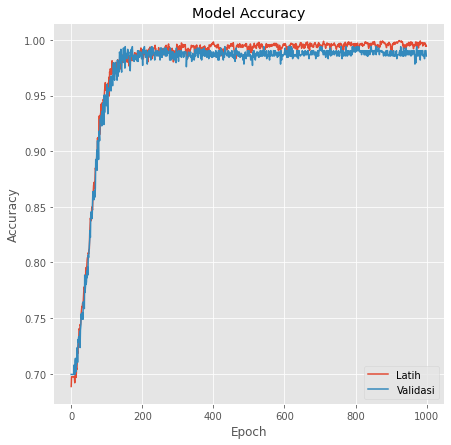

In [13]:
# plot accuracy history
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.set_title('Model Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(['Latih','Validasi'])
plt.savefig('M1(accuracy)_MICNN_without_relu_77x77.png')
plt.show()

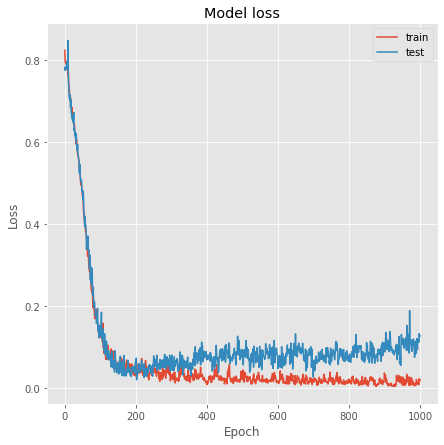

In [14]:
# plot accuracy history
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Model loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
# ax.set_xlim(0,1000)
ax.legend(['train','test'])
plt.savefig('M1(loss)_MICNN_without_relu_77x77.png')
plt.show()

In [15]:
final_loss, final_acc = model_load.evaluate([x_test_Z, x_test_N, x_test_E], y_test,batch_size=128, verbose=1)
print("\nTest data, accuracy: {:5.2f}%".format(100*final_acc))
print("\nTest data, loss: {:5.2f}%".format(100*final_loss))


7/7 [==============================] - 1s 97ms/step - loss: 0.0333 - accuracy: 0.9940

Test data, accuracy: 99.40%

Test data, loss:  3.33%


In [16]:
from sklearn.metrics import classification_report

# print('Finding predicted classes and probabilities to build confusion matrix')
y_pred = model.predict([x_test_Z, x_test_N, x_test_E]) 
y_pred = np.argmax(model.predict([x_test_Z, x_test_N, x_test_E]),axis=1) 
predicted_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(predicted_test, y_pred)

print(cm)


2022-06-25 14:17:00.058229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[570   3   6]
 [  3 187   0]
 [  0   0  59]]


In [17]:
print (classification_report(predicted_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       579
           1       0.98      0.98      0.98       190
           2       0.91      1.00      0.95        59

    accuracy                           0.99       828
   macro avg       0.96      0.99      0.98       828
weighted avg       0.99      0.99      0.99       828



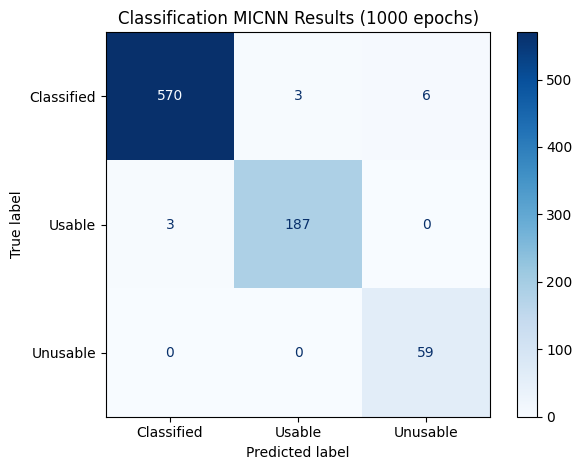

In [18]:
#plot confusion matrix
plt.style.use('default')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Classified','Usable', 'Unusable'])
disp.plot(cmap='Blues', values_format='')
plt.title(f'Classification MICNN Results ({epochs} epochs)')
plt.tight_layout()
plt.savefig('M1(confusion_matrix).png')
plt.show()

In [19]:
#Data_TEST

gray = True
resize = 20

predicted_df = pd.read_csv('data_test.csv', index_col=0)
# predicted_df= predicted_df[['files_name','classID']]
predicted_df['Z'] = predicted_df.index.map(lambda id: f'spectogram_typesquare/{id}_Z.png')
predicted_df['N'] = predicted_df.index.map(lambda id: f'spectogram_typesquare/{id}_N.png')
predicted_df['E'] = predicted_df.index.map(lambda id: f'spectogram_typesquare/{id}_E.png')


#init_preprocess
Z_pred, Z_chan = preprocess_spectogram(predicted_df.Z.values, resize, gray)
N_Pred, N_chan = preprocess_spectogram(predicted_df.N.values, resize, gray)
E_Pred, E_chan = preprocess_spectogram(predicted_df.E.values, resize, gray)

In [53]:
classTarget = [
    'Certified', 
    'Usable', 
    'Unusable'
]

y_pred = model.predict([Z_pred, N_Pred, E_Pred]) 
print(np.argmax(y_pred,axis=1))
# print(' the predicted this stasiun is ## {} ##'.format(classTarget[np.argmax(y_pred[92])]))
# score = tf.nn.log_softmax(y_pred[92])
# tf.nn.log_softmax
# print(' is =={}== accuracy: {:5.2f}%'.format(classTarget[np.argmax(score)],100 * np.max(score)))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [37]:
#Data_UJI

gray = True
resize = 20

predicted_df = pd.read_csv('/Users/litbanggeo/Documents/Kerjaan_litbang/apps/idrip/input/labels_csv/inaseisform_typetwo.csv', index_col=0)
# predicted_df= predicted_df[['files_name','classID']]
predicted_df['Z'] = predicted_df.index.map(lambda id: f'/Users/litbanggeo/Documents/Kerjaan_litbang/apps/idrip/input/spectogram/{id}_Z.png')
predicted_df['N'] = predicted_df.index.map(lambda id: f'/Users/litbanggeo/Documents/Kerjaan_litbang/apps/idrip/input/spectogram/{id}_N.png')
predicted_df['E'] = predicted_df.index.map(lambda id: f'/Users/litbanggeo/Documents/Kerjaan_litbang/apps/idrip/input/spectogram/{id}_E.png')


#init_preprocess
Z_pred, Z_chan = preprocess_spectogram(predicted_df.Z.values, resize, gray)
N_Pred, N_chan = preprocess_spectogram(predicted_df.N.values, resize, gray)
E_Pred, E_chan = preprocess_spectogram(predicted_df.E.values, resize, gray)

In [49]:
classTarget = [
    'Certified', 
    'Usable', 
    'Unusable'
]

y_pred = model.predict([Z_pred, N_Pred, E_Pred]) 
print(' the predicted this stasiun is ## {} ##'.format(classTarget[np.argmax(y_pred[28])]))

 the predicted this stasiun is ## Certified ##
